---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Credit Card fraud detection

In the current project, we will address the issue of credit card frauds, which is considered to be a form of identity theft. Typically, this type of fraud occurs from the illegal charging of purchases or funds removal from another's account due to unauthorised use of the person's credit card information<sup><a href="https://www.law.cornell.edu/wex/credit_card_fraud">1</a></sup>. This type of fraud is a major cause of concern in financial institutions and fintechs globally. According to the Nilson Report, credit card fraud worldwide led to the loss of $28.58 billion in 2020<sup><a href="https://nilsonreport.com/mention/1515/1link/">2</a></sup>.

<p align=center>
<img src="img/cctheft.jpg" width="50%"><br>
<i><sup>Image credits: kjpargeter (<a href="https://www.freepik.com/search?author=938508&authorSlug=kjpargeter&format=author&selection=1">www.freepik.com</a>)</sup></i>
</p>

Thus, credit card frauds are greatly relevant due to their potential to considerably harm both costumers and financial institutions. Another factor to be taken into account are the action to preventively block a credit card due to suspicious activity. If the transaction is genuine, this causes both stress and embarassment to the clients who are denied their purchase.

For the aforementioned reasons, investments in Fraud Detection through Artificial Inteligence are increasing constantly, presenting as a great Data Science oportunity. Slightly better machine learning algorithms, with great volumes of data as a base, already represent millions in economy through fraud avoidance.

## Getting the data

The data that we are using in this project is available on the [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) website. It consists of anonymized credit card transactions, which were labeled as fraudulent or genuine transactions. 

The dataset actually consists of credit card transactions registered in September 2013 by cardholders in Europe. It represents transactions made over the course of two days, where **492 frauds** were identified, out of 284,807 transactions. In total, the operations marked as fraudulent represent only 0.172% of the total dataset, making this dataset highly unbalanced<sup><a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">3</a></sup>.

<p align=center>
<img src="img/ccpayment.jpg" width="50%"><br>
<i><sup>Image credits: freepik (<a href="https://www.freepik.com/free-photo/person-paying-with-its-credit-card_20083164.htm">www.freepik.com</a>)</sup></i>
</p>

In addition, the source informs that the dataset has been through a dimensionality reduction transformation: the Principal Component Analysis (PCA). This was done to protect user identities and other sensitive features in the dataset, while also reducing its complexity.

With the increase in the number of variables in a given dataset, the difficulty to visualize a multi-dimensional hyperspace also increases. The goal of the PCA is to extract important information from this multi-variate data that are inter-correlated. While each variable is considered a different *dimension*, the PCA extracts the information in the dataset as a set of new variables called **principal components**, reducing the number of *dimensions* from the original dataset. These **principal components** correspond to a linear combination of the original variables and their goal is to encapsulate most of the variation present in the dataset<sup><a href="http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/">4</a></sup>.

In our dataset, the **principal components** correspond to the columns in the dataset: $[V1, V2, V3 \dots, Vn]$.

### Loading necessary packages

In [190]:
## Importing packages

# General
import pandas as pd
import numpy as np
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Machine Learning models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

# Tool for dealing with imbalance
from imblearn.under_sampling import RandomUnderSampler

# My own tools
import tools

%matplotlib inline

### Importing the data

For ease of access, since this is a bigger file, we will import it as a direct access link.

In [191]:
file_path = "https://onedrive.live.com/download?cid=A06C4A8AAF3A347B&resid=A06C4A8AAF3A347B%215208&authkey=AAdhamfzp5RS9PM"

# Downloading and reading the file
df = pd.read_csv(file_path)

Now, let's verify basic characteristics of our dataset and subset the `test` data that is going to be used later on.

In [192]:
# Original size
print('Original size of the dataset: ', df.shape[0], ' entries.')

# Separating test data
test = df.sample(frac=0.15, random_state=42)

# Removing test data from regular df
df = df.drop(test.index)

# Test dataset size
print('Test dataset size: ', test.shape[0], ' entries.')
print('Remaining dataset size: ', df.shape[0], ' entries.')

Original size of the dataset:  284807  entries.
Test dataset size:  42721  entries.
Remaining dataset size:  242086  entries.


Having imported the data, we can begin the exploratory analysis of the dataset while also preparing the data to use in a **machine learning** model.

## Exploratory analysis

To begin our analysis, let us look a the first entries of the dataframe:

In [193]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0


From this initial look, we can see that our data is entirely numeric after the dimensionality reduction (the *Principal Component Analysis*). Follow [this link](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) if you want to know more about the method.

The only values that were preserved were the columns:
* `Time`: Number of seconds elapsed between this transaction and the first transaction in the dataset;
* `Amount`: Value that represents the transaction amount;
* `Class`: Binary coded variable, with '1' representing fraudulent transactions and '0' representing regular ones.

Now, let us do descriptive statistics on the dataset and check if there are any missing values:

In [194]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,...,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000
mean,94790.585432,0.001153,-0.000866,-0.000249,-0.000743,-0.000391,-0.000532,0.000951,-0.000115,0.000864,...,0.000640,-0.000997,-0.000196,0.000017,-0.000824,-0.000040,-0.000628,0.000409,88.612138,0.001727
std,47488.557251,1.956206,1.653385,1.513529,1.414942,1.384288,1.334177,1.239964,1.189191,1.097059,...,0.733873,0.725555,0.630782,0.605192,0.521516,0.482538,0.402632,0.331341,254.851246,0.041517
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000,0.000000
25%,54156.000000,-0.920932,-0.598121,-0.890516,-0.848834,-0.690313,-0.768634,-0.552487,-0.208175,-0.642411,...,-0.228369,-0.543000,-0.161417,-0.354494,-0.317682,-0.327258,-0.070913,-0.052945,5.560000,0.000000
50%,84676.000000,0.018265,0.065809,0.179657,-0.019657,-0.055903,-0.274238,0.041138,0.022436,-0.050819,...,-0.029438,0.005658,-0.010732,0.040809,0.014962,-0.052117,0.001301,0.011338,22.000000,0.000000
75%,139309.000000,1.315404,0.803877,1.025325,0.742531,0.610267,0.397241,0.570192,0.327822,0.598923,...,0.186394,0.527999,0.148084,0.439855,0.350598,0.241024,0.091082,0.078298,77.290000,0.000000
max,172792.000000,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [195]:
# Checking for null values
df.isnull().sum().max()

0

As we can see, we have no columns that contain missing values in our dataset, as indicated above. As for our numeric data, we can already see that we have possible outliers, indicated by min/max values that are distant from the mean or median of the variables. Before checking the outliers, let's see how (un)balanced our dataset is.

0    241668
1       418
Name: Class, dtype: int64

These frauds represent 0.1727% of the dataset.



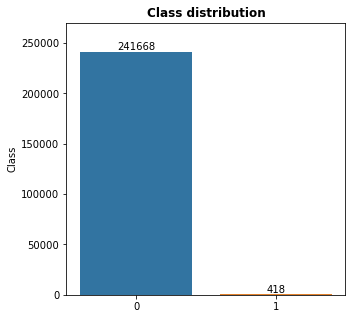

In [196]:
# Count class values
print(df.Class.value_counts())

# How much %? Does it match the number stated by the provider?
print('\nThese frauds represent {:.4f}% of the dataset.\n'.format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# Plotting barplot
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(x=df.Class.unique(), y=df.Class.value_counts(), data=df, ax=ax)
ax.set_title('Class distribution', fontsize=12, weight='bold')
ax = plt.gca()
ax.set_ylim([0, 270000])
ax.bar_label(ax.containers[0]);


To further investigate the presence of outliers and other features of the dataset, we will look at some plots, namely histograms of the `time` and `amount` variables either from normal or fraudulent transactions separately and a boxplot of `amount` in fraudulent transactions.

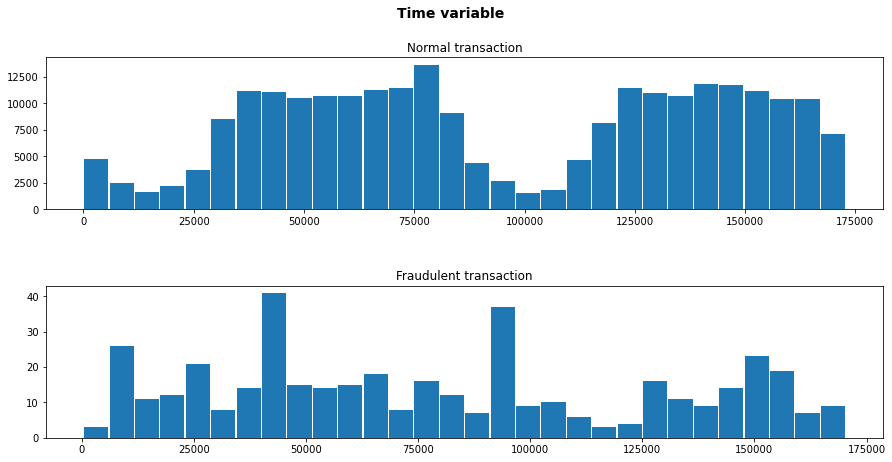

In [197]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

axes[0].hist(df.Time[df.Class==0], bins=30, rwidth=0.95)
axes[0].set_title('Normal transaction', fontsize=12)
counts, bins, bars = axes[1].hist(df.Time[df.Class==1], bins=30, rwidth=0.95)
axes[1].set_title('Fraudulent transaction', fontsize=12)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('Time variable', fontsize=14, weight='bold');


In [198]:
# Estimating how much time between the peaks in transactions
timeHistDict = dict(zip(counts, bins))

keys = list(timeHistDict.keys())
keys.sort(reverse=True)
keys = keys[0:2]

count = 1

for key in keys:

    print('Peak #' + str(count) + ' occurs after around ' + str(int(round(timeHistDict.get(key),0))) + ' seconds, or, roughly, around ' + str(int(round(timeHistDict.get(key)/3600,0))) + ' hours after the first transaction.')
    count += 1


Peak #1 occurs after around 40059 seconds, or, roughly, around 11 hours after the first transaction.
Peak #2 occurs after around 91042 seconds, or, roughly, around 25 hours after the first transaction.


From the time data, we can see that normal transactions occur in a continuous pattern over two periods (represented by the broad peaks in the first histogram) of time. These probably represent "regular" day hours, where we would expect most people to be actively making purchases. However, we lack information about the actual time of the transactions and are unable to conclude any further.

Although we can estimate how much time elapse between the peaks in transaction frauds, without the information mentioned above we cannot say what time of day these frauds were more frequent. However, if the broad peaks do represent daytime activity, the second peak in fraudulent transactions could represent operations being made at night which are, potentially, transactions which would take some time before alarming the owner of the credit card, considering most people are sleeping at nighttime.

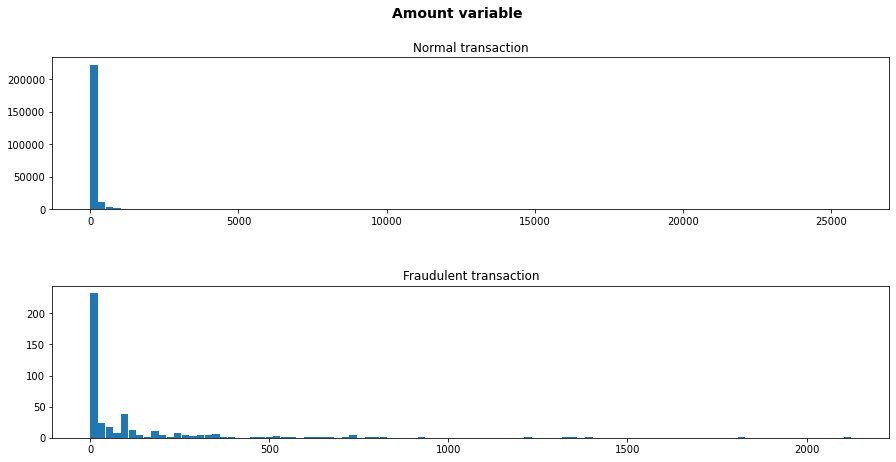

In [199]:
fig, axes = plt.subplots(2, 1, figsize=(15,7))

axes[0].hist(df.Amount[df.Class==0], bins=100, rwidth=0.95)
axes[0].set_title('Normal transaction', fontsize=12)
axes[1].hist(df.Amount[df.Class==1], bins=100, rwidth=0.95)
axes[1].set_title('Fraudulent transaction', fontsize=12)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('Amount variable', fontsize=14, weight='bold');

As we can see in the histograms for the `amount` variable, regular transactions do not appear to have outliers as most of the data falls around one peak in value. However, for fraudulent transations, we have an increased span of values, up to over $2000. Let us see how these features look in boxplots:

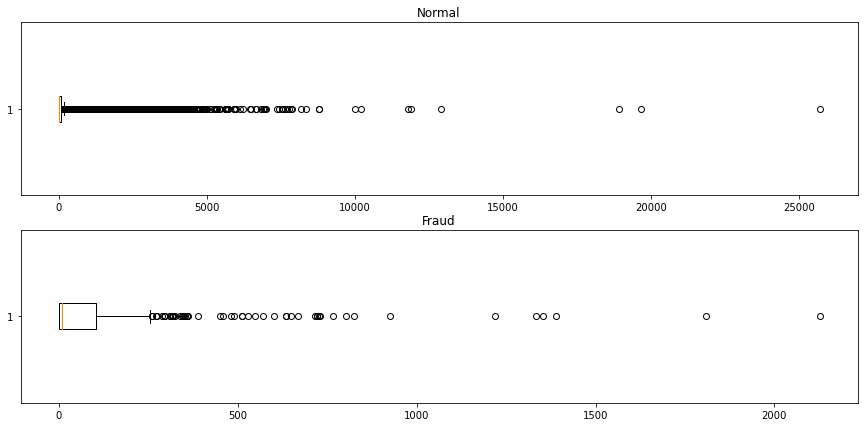

In [200]:
# Plotting boxplots
fig, axes = plt.subplots(2, 1, figsize=(15,7))

axes[0].boxplot(df.Amount[df.Class==0], vert=False)
axes[0].set_title("Normal")
axes[1].boxplot(df.Amount[df.Class==1], vert=False)
axes[1].set_title("Fraud");


From this, we can see that normal transactions also have outliers. However, in both cases these transactions represent real data. This is important, as machine learning techniques have to take these characteristics into account when predicting fraudulent transactions from regular ones.

For now, in summary, we know that the dataset is heavily unbalanced and that `Time` and `Amount` variables are not standardized. Since we are dealing with a PCA transformation, we assume that the features have been standardized beforehand. As for the *unbalancing* of the dataset, it has been previously demonstrated that **class imbalance** is not always a problem for classifiers *per se*<sup><a href="https://www.researchgate.net/profile/Duke-Taeho-Jo/publication/220520142_Class_imbalances_versus_small_disjuncts/links/53fe8cf40cf21edafd151816/Class-imbalances-versus-small-disjuncts.pdf">5</a></sup>. Thus, we will test how the imbalance will impact our models.

## Data preparation

### Feature scaling/data standardization

Since `Time` and `Amount` represent two very different types of measurement, these variables are in different scales. Since the variables have outliers, we will apply the **standardization** (or Z-score transformation) technique before splitting the dataset.

In [201]:
# Copying df
df_std = df.copy()

# Defining scaler
std_scaler = StandardScaler()

# Standardizing and droping old vars
df_std['Std_Time'] = std_scaler.fit_transform(df_std['Time'].values.reshape(-1, 1))
df_std['Std_Amount'] = std_scaler.fit_transform(df_std['Amount'].values.reshape(-1, 1))

df_std.drop(['Time', 'Amount'], axis=1, inplace=True)

In [202]:
# Checking new vars
df_std[['Std_Time', 'Std_Amount']].describe()

,Std_Time,Std_Amount
count,2.420860e+05,2.420860e+05
mean,-1.490656e-17,3.658275e-16
std,1.000002e+00,1.000002e+00
min,-1.996076e+00,-3.477021e-01
25%,-8.556729e-01,-3.258854e-01
50%,-2.129904e-01,-2.613771e-01
75%,9.374575e-01,-4.442655e-02
max,1.642534e+00,1.004610e+02


Now that the variables are transformed, let us split our dataset into train and test data. Since we are using an imbalanced dataset, it is recommended to use a *stratified sampling* approach to splitting the dataset to preserve relative class frequencies<sup><a href="https://scikit-learn.org/stable/modules/cross_validation.html#stratification">6</a></sup>. After that, we will also implement an approach to rebalance the dataset (while also preserving the original data) to test the influence it will have on our models.

In [203]:
# Extracting target
y = df_std['Class']
X = df_std.drop('Class', axis=1)

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

To verify wether or not the imbalance in the dataset actually represents and issue for classifying fraudulent transactions, we will employ a method called **Random Under Sampling** (RUS), from the *imbalanced-learn* library, to balance the dataset. This method works by randomly selecting samples from our default (normal transactions) class to match the number of samples in our class of interest (fraud), which is the minority class in the dataset.

0    313
1    313
Name: Class, dtype: int64


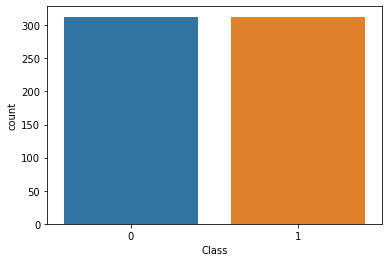

In [204]:
# Defining random under sampler
rus = RandomUnderSampler()

# Creating new train sets
X_under, y_under = rus.fit_resample(X_train, y_train)

# Checking the balancing
print(y_under.value_counts())
sns.countplot(x=y_under);

Now that we have successfully balanced our dataset, let's look at a correlation plot to see how this affected the relationship between the features.

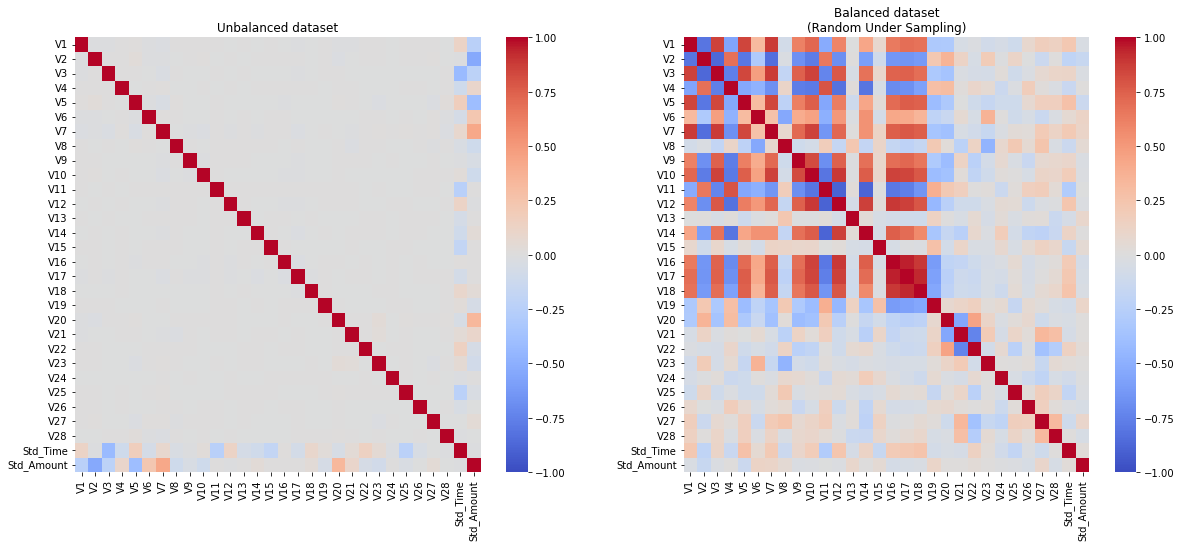

In [205]:
# Calculating correalations
corr = X_train.corr()
corr_under = X_under.corr()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20,8))

axes[0].set_title('Unbalanced dataset')
sns.heatmap(corr, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Balanced dataset\n(Random Under Sampling)')
sns.heatmap(corr_under, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1);



We can see that over half of our features acquire some correlation after filtering the dataset. In addition, some of the correlations (even if weaker ones) in the variables `Amount` and `Time` change after rebalancing the dataset, indicating that this is not a good way of evaluating the relationship between these variables and the features of our dataset.

Still, we will use our machine learning model to determine wether or not it is better to balance the dataset in this case.

## Machine Learning model

Now we will build a model to ***classify*** our data wether they represent fraudulent transactions or not. Since we are talking about a *binary* outcome, one of the models that are suited to this classification is the **binary Logistic Regression**. Another model useful for classification is the **Random Forest* classifier. Here, we will test both these models.

### Logistic Regression

This type of regression, also called logit model or logit regression, is often used to classify or predict an outcome. Speaking simply, it works by estimating the **probability** of occurrence of an event, base on one or more independent variables (also termed *predictors*)<sup><a href="https://www.ibm.com/topics/logistic-regression">6</a></sup>.

Now, we will build two models: one using the unbalanced dataset, and another using the balanced dataset after the [RUS](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) approach.

#### Building the *unbalanced* model

In [206]:
# Setting seed
np.random.seed(42)

# Creating and training the Unbalanced Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting using this model
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

#### Building the *balanced* model

In [207]:
# Setting seed
np.random.seed(42)

# Creating and training the Balanced Logistic Regression model
model_RUS = LogisticRegression()
model_RUS.fit(X_under, y_under)

# Predicting using this model
y_pred_RUS = model_RUS.predict(X_val)
y_proba_RUS = model_RUS.predict_proba(X_val)

### Random Forest

The random forest is a supervised model that works by building different *decision trees* to reach a single result that better classifies the data<sup><a ref="https://www.ibm.com/cloud/learn/random-forest">7</a></sup>. Now, let us build the models for both our datasets again.

#### Building the *unbalanced* model

In [208]:
# Setting seed
np.random.seed(42)

# Creating and training the Unbalanced Logistic Regression model
forest = RandomForestClassifier(criterion='entropy')
forest.fit(X_train, y_train)

# Predicting using this model
y_forest_pred = forest.predict(X_val)
y_forest_proba = forest.predict_proba(X_val)

#### Building the *balanced* model

In [209]:
# Setting seed
np.random.seed(42)

# Creating and training the Unbalanced Logistic Regression model
forest_RUS = RandomForestClassifier(criterion='entropy')
forest_RUS.fit(X_under, y_under)

# Predicting using this model
y_forest_RUS_pred = forest_RUS.predict(X_val)
y_forest_RUS_proba = forest_RUS.predict_proba(X_val)

### Evaluating our models

As we said before, our dataset is a very unbalanced one. For this reason, due to the [*Accuracy Paradox*](https://en.wikipedia.org/wiki/Accuracy_paradox), measuring the accuracy of the model alone is not a good metric to evaluate our model. As such, we will also be looking at *precision*, *recall* and something known as the [AUC - ROC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc), or ****A***rea ***U***nder the ***C***urve* of the ****R***eceiver ***O***perating ***C***haracteristic* curve. This type of measure takes into account the True Positive Rate and the False Positive Rate, which means it considers both the classes in its evaluation.

Let's see how both our models behave.

#### Confusion matrices

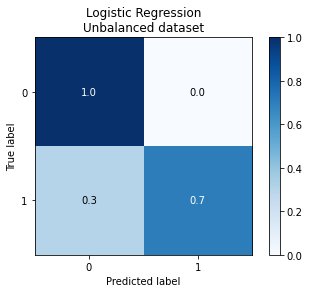

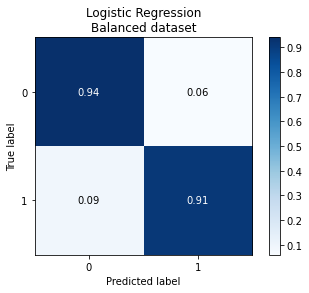

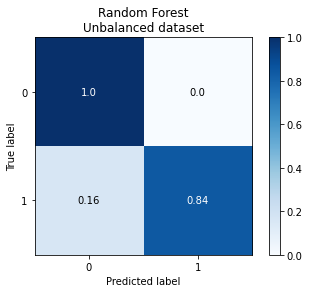

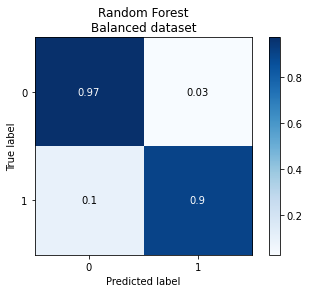

In [210]:
# Plotting confusion matrices
skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True, title='Logistic Regression\nUnbalanced dataset')
skplt.metrics.plot_confusion_matrix(y_val, y_pred_RUS, normalize=True, title='Logistic Regression\nBalanced dataset')
skplt.metrics.plot_confusion_matrix(y_val, y_forest_pred, normalize=True, title='Random Forest\nUnbalanced dataset')
skplt.metrics.plot_confusion_matrix(y_val, y_forest_RUS_pred, normalize=True, title='Random Forest\nBalanced dataset');

#### Classification reports

In [211]:
print('Logistic Regression - Unbalanced:\n', classification_report(y_val, y_pred, digits=4))
print('Logistic Regression - Balanced:\n', classification_report(y_val, y_pred_RUS, digits=4))
print('Random Forest - Unbalanced:\n', classification_report(y_val, y_forest_pred, digits=4))
print('Random Forest - Balanced:\n', classification_report(y_val, y_forest_RUS_pred, digits=4))

Logistic Regression - Unbalanced:
               precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     60417
           1     0.9125    0.6952    0.7892       105

    accuracy                         0.9994     60522
   macro avg     0.9560    0.8476    0.8944     60522
weighted avg     0.9993    0.9994    0.9993     60522

Logistic Regression - Balanced:
               precision    recall  f1-score   support

           0     0.9998    0.9372    0.9675     60417
           1     0.0247    0.9143    0.0481       105

    accuracy                         0.9372     60522
   macro avg     0.5123    0.9258    0.5078     60522
weighted avg     0.9981    0.9372    0.9659     60522

Random Forest - Unbalanced:
               precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     60417
           1     0.9778    0.8381    0.9026       105

    accuracy                         0.9997     60522
   macro avg     0.9887    0.91

#### Area Under the Curve - ROC

In [212]:
# imprimir a área sob da curva
print("AUC Logistic Regression - Unbalanced: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))
print("AUC Logistic Regression - Balanced: {:.4f}\n".format(roc_auc_score(y_val, y_pred_RUS)))
print("AUC Random Forest - Unbalanced: {:.4f}\n".format(roc_auc_score(y_val, y_forest_pred)))
print("AUC Random Forest - Balanced:: {:.4f}\n".format(roc_auc_score(y_val, y_forest_RUS_pred)))   

AUC Logistic Regression - Unbalanced: 0.8476

AUC Logistic Regression - Balanced: 0.9258

AUC Random Forest - Unbalanced: 0.9190

AUC Random Forest - Balanced:: 0.9358



#### Metrics summary

## Avaliar o desempenho do modelo

* Identificar a melhor métrica para esse tipo de modelo
* [*Opcional*] Comparar o desempenho entre diversos modelos

## Conclusão

* Escrever suas conclusões a respeito da construção do modelo